## Power Analysis

**Gregory Way, 2019**

Power to detect differences between wild-type and resistant clones at different sample sizes.

This analysis was performed using `HCT116` cell lines treated with Bortezomib.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(pwr))

In [2]:
get_effect_size <- function(group_a, group_b) {
    length_a <- length(group_a) - 1
    length_b <- length(group_b) - 1
    mean_difference <- abs(mean(group_a) - mean(group_b))
    
    common_std <- length_a * var(group_a) + length_b * var(group_b)
    common_std <- common_std / (length_a + length_b)
    effect_size <- mean_difference / sqrt(common_std)
    return(effect_size)
}

In [3]:
# Load Profiles
batch <- "2019_06_25_Batch3"
file <- file.path("data", paste0(batch, "_merged_intersected_variable_selected.csv"))

full_df <- readr::read_csv(file, col_types = readr::cols())
print(dim(full_df))
head(full_df, 3)

[1] 105 191


Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,⋯,Nuclei_Texture_Correlation_AGP_20_00,Nuclei_Texture_Correlation_AGP_20_03,Nuclei_Texture_Correlation_AGP_5_00,Nuclei_Texture_Correlation_ER_20_02,Nuclei_Texture_Correlation_Mito_5_00,Nuclei_Texture_Correlation_RNA_20_02,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_AGP_20_02,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_InverseDifferenceMoment_ER_20_02
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MutClones,B02,MutClones,MutClones,B02,BZ001,0.6034418,-3.057030,0.05068862,0.6585738,⋯,3.3582920,1.126295,0.000000,1.204256,0.42066821,0.5705776,-1.320394,-0.2247533,1.311671,0.212493
MutClones,B03,MutClones,MutClones,B03,BZ002,-1.0295421,-1.419110,1.11426953,-0.9345095,⋯,-0.3068762,1.536572,-4.293160,3.379792,-6.81572415,0.4181798,3.899485,2.1667509,2.502230,2.646517
MutClones,B04,MutClones,MutClones,B04,BZ003,1.6599068,-1.161031,-1.71337361,-0.2834930,⋯,4.4402692,1.169331,2.445327,4.378964,0.08634202,0.9786170,-2.408064,-0.1248563,0.000000,1.157526


In [4]:
# Extract out mutant vs. wildtype clones
mut_df <- full_df %>% dplyr::filter(Metadata_Assay_Plate_Barcode == "MutClones")
wt_df <- full_df %>% dplyr::filter(Metadata_Assay_Plate_Barcode == "WTClones")

In [5]:
# Get all cp features
cp_features <- colnames(full_df %>% dplyr::select(-starts_with("Metadata_")))

In [6]:
testing_ns <- c(10, 25, 50, 75, 100, 250, 500, 750, 1000, 2000, 5000, 10000)
alpha <- 0.05 / length(cp_features)
current_n <- dim(full_df)[1] / 2

In [7]:
all_effect_size_results <- list()
idx <- 0
for (feature in cp_features) {
    group_a <- wt_df %>% dplyr::pull(!!feature)
    group_b <- mut_df %>% dplyr::pull(!!feature)
    feature_effect_size <- get_effect_size(group_a, group_b)
    
    for (example_n in testing_ns) {
        power_result <- pwr.t.test(n = example_n, d = feature_effect_size, sig.level = alpha)
        obs_power <- power_result$power
        result <- c(feature, example_n, obs_power)
        all_effect_size_results[[paste(idx)]] <- result
        idx <- idx + 1
    }

}

In [8]:
full_results_df <- all_effect_size_results %>%
    dplyr::bind_cols() %>%
    t() %>%
    tibble::as_tibble(.name_repair = "minimal")

colnames(full_results_df) <- c("feature", "n", "power")

full_results_df$n <- as.numeric(paste(full_results_df$n))
full_results_df$power <- as.numeric(paste(full_results_df$power))

print(dim(full_results_df))
head(full_results_df)

[1] 2220    3


feature,n,power
<chr>,<dbl>,<dbl>
Cells_AreaShape_Compactness,10,0.001513428
Cells_AreaShape_Compactness,25,0.007152174
Cells_AreaShape_Compactness,50,0.029011816
Cells_AreaShape_Compactness,75,0.069656419
Cells_AreaShape_Compactness,100,0.129366779
Cells_AreaShape_Compactness,250,0.644816880


In [9]:
summary_df <- full_results_df %>% dplyr::group_by(n) %>%
    dplyr::mutate(mean_power = mean(power),
                  stderr_power = sd(power) / sqrt(length(power))) %>%
    dplyr::distinct(n, mean_power, stderr_power)
summary_df

n,mean_power,stderr_power
<dbl>,<dbl>,<dbl>
10,0.0009030063,9.125435e-05
25,0.0042616565,8.352789e-04
50,0.0170553628,3.503282e-03
75,0.0371219742,6.535189e-03
100,0.0619123608,9.505221e-03
250,0.2204356251,2.254675e-02
500,0.3870676347,2.948518e-02
750,0.4803353987,3.124168e-02
1000,0.5409444484,3.166719e-02


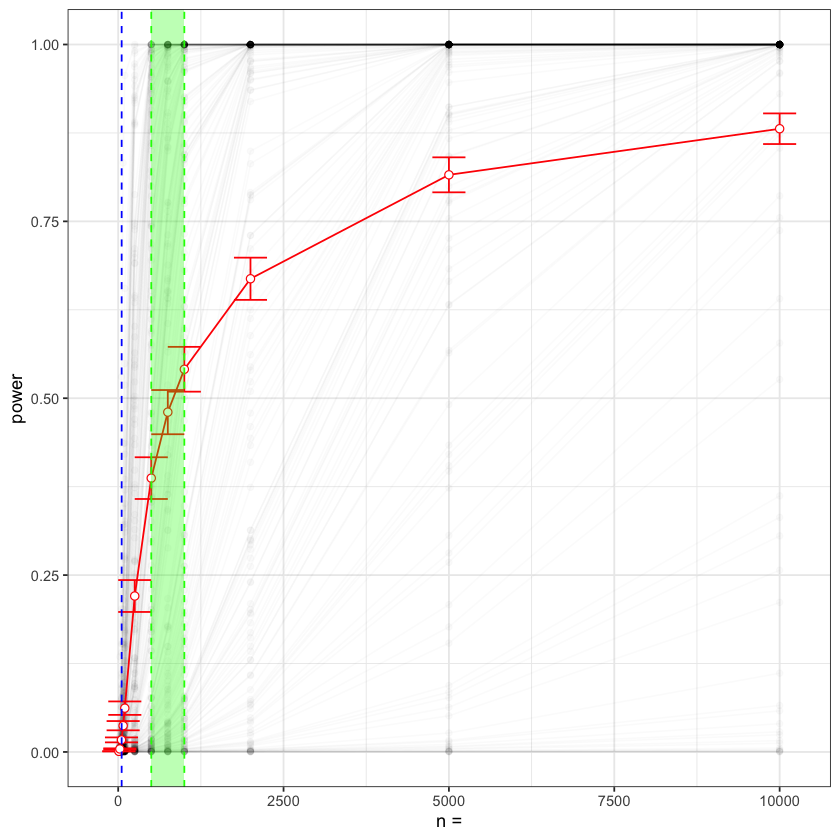

In [10]:
rect <- data.frame(xmin = 500, xmax = 1000, ymin = -Inf, ymax = Inf)

power_gg <- ggplot(full_results_df) +
    geom_line(aes(x = n, y = power, group = feature),
              alpha = 0.02) +
    geom_point(aes(x = n, y = power, group = feature),
              alpha = 0.02) +
    geom_errorbar(data = summary_df,
                  color = "red",
                  width = 500,
                  aes(x = n,
                      ymin = mean_power - stderr_power,
                      ymax = mean_power + stderr_power)) +
    geom_line(data = summary_df,
              color = "red",
              aes(x = n, y = mean_power)) +
    geom_point(data = summary_df,
               color = "red",
               size = 2,
               shape = 21,
               fill = "white",
               aes(x = n, y = mean_power)) +
     geom_rect(data = rect,
               inherit.aes=FALSE,
               aes(xmin = xmin,
                   xmax = xmax,
                   ymin = ymin,
                   ymax = ymax),
               color="transparent",
               fill="green", alpha=0.3) +
    geom_vline(xintercept = current_n,
               linetype = "dashed",
               color = "blue") +
    geom_vline(xintercept = 500,
               linetype = "dashed",
               color = "green") +
    geom_vline(xintercept = 1000,
               linetype = "dashed",
               color = "green") +
    xlab("n =") +
    ylab("power") +
    theme_bw()

output_file <- file.path("figures", "power_analysis.png")
ggsave(output_file, dpi = 500, height = 6, width = 6)

power_gg